### Reference: https://www.youtube.com/watch?v=n9_XyCGr-MI&t=5023s

In [1]:
# run this in order to access gcs bucket
from google.colab import auth
auth.authenticate_user()

In [2]:
from google.cloud import storage

In [40]:
from collections import Counter, defaultdict
from datetime import datetime
import io
import os
import numpy as np
import pandas as pd
from PIL import Image

In [4]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT
from tqdm import tqdm

In [6]:
torch.__version__

'2.5.1+cu121'

In [7]:
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
architecture_config = [
    # Tuple: (kernel_size, num_filters, stride, padding)
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    # List: tuples, last interger represents number of repeats
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


### Models

In [9]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [10]:
# test CNNBlock
test_cnn_block = CNNBlock(in_channels=3, out_channels=32, kernel_size=3).to(device)
B, C, H, W = 5, 3, 28, 28
x = torch.randn((B, C, H, W)).to(device)
y = test_cnn_block(x)
print(y.shape)

torch.Size([5, 32, 26, 26])


In [11]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple: # Tuple: (kernel_size, num_filters, stride, padding)
                layers.append(
                    CNNBlock(in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3])
                )
                in_channels = x[1]

            elif type(x) == str: # String: "M"
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))

            elif type(x) == list: # List: tuples, last interger represents number of repeats
                conv1 = x[0]  # Tuple: (kernel_size, num_filters, stride, padding)
                conv2 = x[1]
                num_repeats = x[2]
                for _ in range(num_repeats):
                    layers.append(CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2], padding=conv1[3]))
                    layers.append(CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3]))
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)) # later to be reshaped to (S, S, 30), where C + B * 5 = 20 + 2 * 5 = 30
        )


In [12]:
# test Yolov1
batch_size = 5
in_channels = 3
width = 448
height = 448
x = torch.randn((batch_size, in_channels, width, height)).to(device)
print(x.shape)

yolo = Yolov1(in_channels=in_channels, split_size=7, num_boxes=2, num_classes=20).to(device)
pred = yolo(x)
print(pred.shape)

torch.Size([5, 3, 448, 448])
torch.Size([5, 1470])


In [13]:
S = 7
B = 2
C = 20
predictions = pred.reshape(-1, S, S, C + B * 5)

### Utility functions

In [14]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    parameters
        boxes_preds: (batch_size, 4)
        boxes_labels: (batch_size, 4)
        box_format: "midpoint" (x,y,w,h) or "corners" (x1,y1,x2,y2)
    """
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2

        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]

        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]
    else:
        raise ValueError("box_format must be 'midpoint' or 'corners'")

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) to handle the case that there is not intersection
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)


In [15]:
def non_max_suppression(bboxes, iou_threshold, prob_threshold, box_format="corners"):
    """
    Parameters:
        bboxes: list of lists containing all bounding boxes, [box1, box2, ...]
          box_i = [class, class_prob, x1, y1, x2, y2]
        iou_threshold:
        prob_threshold:
        box_format:

    Returns:
        list: bounding boxes after performing non-max suppression
    """
    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > prob_threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    print(f'begin while loop')

    while bboxes:
        chosen_box = bboxes.pop(0)

        # identify the boxes to keep in this iteration
        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]), torch.tensor(box[2:]), box_format=box_format
            ) < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    print(f'end while loop')


    return bboxes_after_nms

In [16]:
iou_b1 = intersection_over_union(
    predictions[..., 21: 25],
    predictions[..., 21: 25],
)
print(iou_b1.shape, iou_b1.unsqueeze(0).shape)

iou_b2 = intersection_over_union(
    predictions[..., 26: 30],
    predictions[..., 21: 25],
)
print(iou_b2.shape, iou_b2.unsqueeze(0).shape)

ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
ious.shape

torch.Size([5, 7, 7, 1]) torch.Size([1, 5, 7, 7, 1])
torch.Size([5, 7, 7, 1]) torch.Size([1, 5, 7, 7, 1])


torch.Size([2, 5, 7, 7, 1])

In [17]:
def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5, box_format="corners", num_classes=20):
    """
    Parameters:
        pred_boxes: [box1, box2, ...], box_i = [train_idx, class, class_prob, x1, y1, x2, y2]
        true_boxes: [box1, box2, ...], same as pred_boxes
        iou_threshold:
        box_format:
        num_classes:

    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    average_precisions = []
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # count how many true bounding boxes each image has
        # amount_bboxes = {'img0': 3, 'img1': 5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # expand the counter to a tensor, for tracking if a true bounding box
        #  has been processed or not
        # amount_bboxes = {'img0': tensor([0,0,0]), 'img1': tensor([0,0,0,0,0])}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True) # sort by prob. in descending order
        TP = torch.zeros(len(detections))
        FP = torch.zeros(len(detections))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            ground_truth_img = [bbox for bbox in ground_truths if bbox[0] == detection[0]]

            best_iou = 0
            best_gt_idx = None
            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:7]),
                    torch.tensor(gt[3:7]),
                    box_format=box_format,
                )
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        # add a point (1, 0) to the precision-recall curve
        #  precision is ont the y-axis, recall the x-axis
        precisions = torch.cat((torch.tensor([1.]), precisions))
        recalls = torch.cat((torch.tensor([0.]), recalls))

        average_precisions.append(
            torch.trapz(precisions, recalls).detach().item()
        )

    return sum(average_precisions) / len(average_precisions)

### Loss function

In [20]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")
        self.S = S
        self.B = B
        self.C = C
        self.lambda_coord = 5
        self.lambda_noobj = 0.5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        iou_b1 = intersection_over_union(
            predictions[..., 21: 25],
            target[..., 21: 25],
        )

        iou_b2 = intersection_over_union(
            predictions[..., 26: 30],
            target[..., 21: 25],
        )

        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        iou_maxes, best_box = torch.max(ious, dim=0)

        exists_box = target[..., 20:21] # identity^{obj}_{ij}, if cell-i has an object or not
        # exists_box ha shpae: (batch, S, S, 1)

        # box coordinates loss
        box_predictions = exists_box * (
            (
                (1 - best_box) * predictions[..., 21: 25]  # if the first box has higher IoU
                + best_box * predictions[..., 26: 30]  # if the second box has higher IoU
            )
        ) # (batch_size, S, S, 4)

        box_targets = exists_box * target[..., 21: 25] # (batch_size, S, S, 4)

        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )

        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2), # (batch, S, S, N) -> (batch * S * S, 4)
            torch.flatten(box_targets, end_dim=-2) # (batch, S, S, N) -> (batch * S * S, 4)
        )


        # object loss
        pred_box = (
            (1 - best_box) * predictions[..., 20:21] + best_box * predictions[..., 25:26]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box, start_dim=1), # (N, S, S, 1) -> (N, S*S)
            torch.flatten(exists_box * target[..., 20:21], start_dim=1) # (N, S, S, 1) -> (N, S*S)
        )

        # no object loss
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1), # (N, S, S, 1) -> (N, S*S)
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1) # (N, S, S, 1) -> (N, S*S)
        )
        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1), # (N, S, S, 1) -> (N, S*S)
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1) # (N, S, S, 1) -> (N, S*S)
        )

        # class loss
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2), # (batch, S, S, C) -> (batch * S * S, C)
            torch.flatten(exists_box * target[..., :20], end_dim=-2) # (batch, S, S, C) -> (batch * S * S, C)
        )

        # sum up all components
        loss = (
            self.lambda_coord * box_loss
            + object_loss
            + self.lambda_noobj * no_object_loss
            + class_loss
        )

        return loss


In [21]:
def generate_random_target(batch_size=5*7*7, num_classes=20, num_boxes=2):
    indices = torch.randint(0, num_classes, (batch_size,))
    one_hot_classes = torch.nn.functional.one_hot(indices, num_classes=num_classes)
    p = torch.ones((batch_size, 1))
    box = torch.rand((batch_size, 4))
    target = torch.cat([one_hot_classes, p, box], dim=-1)
    return target

def generate_random_predictions(batch_size=5*7*7, num_classes=20, num_boxes=2):
    indices = torch.randint(0, num_classes, (batch_size,))
    one_hot_classes = torch.nn.functional.one_hot(indices, num_classes=num_classes)
    p1 = torch.randint(0, 2, (batch_size, 1))
    box1 = torch.randn((batch_size, 4))
    p2 = torch.randint(0, 2, (batch_size, 1))
    box2 = torch.randn((batch_size, 4))
    predictions = torch.cat([one_hot_classes, p1, box1, p2, box2], dim=-1)
    return predictions

S = 7
batch_size = 5 * S * S
num_classes = 20
num_boxes = 2

target = generate_random_target()
target = target.reshape(-1, S, S, num_classes + 1 + 4)
predictions = generate_random_predictions()
print(target.shape, predictions.shape)

torch.Size([5, 7, 7, 25]) torch.Size([245, 30])


In [22]:
yolo_loss_func = YoloLoss()
loss = yolo_loss_func(predictions, target)
print(loss)

tensor(6601.0332)


### Data

In [23]:
class PascalVOCDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, bucket_name, dataset_name, S=7, B=2, C=20, transform=None):
        if 'examples.csv' in csv_path:
            self.annotations = pd.read_csv(csv_path, header=0)
        else:
            self.annotations = pd.read_csv(csv_path, header=None)
        self.bucket_name = bucket_name
        self.dataset_name = dataset_name
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

        self.client = storage.Client()
        self.bucket = self.client.get_bucket(bucket_name)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        # get image
        blob_name = f'{self.dataset_name}/images/{self.annotations.iloc[index, 0]}'
        blob = self.bucket.blob(blob_name)
        image_bytes = blob.download_as_bytes()
        image = Image.open(io.BytesIO(image_bytes))

        # get labels, i.e. class and bounding boxes
        label_path = f'gs://{self.bucket_name}/{self.dataset_name}/labels/{self.annotations.iloc[index, 1]}'
        label_df = pd.read_csv(label_path, header=None, sep=' ')

        boxes = []
        for _, line in label_df.iterrows():
            class_label, x, y, w, h = line.values
            class_label = int(class_label)
            x, y, w, h = float(x), float(y), float(w), float(h)
            box = [class_label, x, y, w, h]
            boxes.append(box)
        boxes = torch.tensor(boxes)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        label_matrix = torch.zeros((self.S, self.S, self.C + 5))
        for box in boxes:
            class_label, x, y, w, h = box.tolist()
            class_label = int(class_label)
            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i
            w_cell, h_cell = w * self.S, h * self.S
            if label_matrix[i, j, 20] == 0:
                label_matrix[i, j, 20] = 1
                box_coordinates = torch.tensor([x_cell, y_cell, w_cell, h_cell])
                label_matrix[i, j, 21:25] = box_coordinates
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

In [24]:
class CustomCompose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

### Trainning loop

In [27]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print(f"Saving checkpoint to {filename}")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
    print(f"Loading checkpoint from {checkpoint}")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

In [28]:
seed = 1223
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [44]:
BUCKET_NAME = 'my-ml-dataset'
DATASET_NAME = 'pascalvoc-yolo'

LEARNING_RATE = 2e-5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
WEIGHT_DECAY = 0
EPOCHS = 40
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "yolov1_model.pt.tar"


In [45]:
def train_one_epoch(train_loader, model, optimizer, loss_func):
    loop = tqdm(train_loader, leave=True)
    losses = []
    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_func(out, y)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    print(f"Meean loss: {sum(losses) / len(losses)}")
    return sum(losses) / len(losses)

In [46]:
def main_func():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_func = YoloLoss(S=7, B=2, C=20)

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    transform = CustomCompose([transforms.Resize((448, 448)), transforms.ToTensor()])

    train_csv_path = f'gs://{BUCKET_NAME}/{DATASET_NAME}/100examples.csv'
    train_dataset = PascalVOCDataset(train_csv_path, BUCKET_NAME, DATASET_NAME, transform=transform)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        #num_workers=NUM_WORKERS,
        #pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=False
    )

    best_loss = float('inf')

    history = defaultdict(list)

    for epoch_idx in range(EPOCHS):

        avg_loss = train_one_epoch(train_loader, model, optimizer, loss_func)
        history['train_loss'].append(avg_loss)

        if avg_loss < best_loss:
            best_loss = avg_loss
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
            }
            save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
        print(f'finish epoch {epoch_idx}, time: {datetime.now().strftime("%Y-%m-%d %H:%M:%S") }')

    return history


In [ ]:
history = main_func()

Text(0, 0.5, 'Loss')

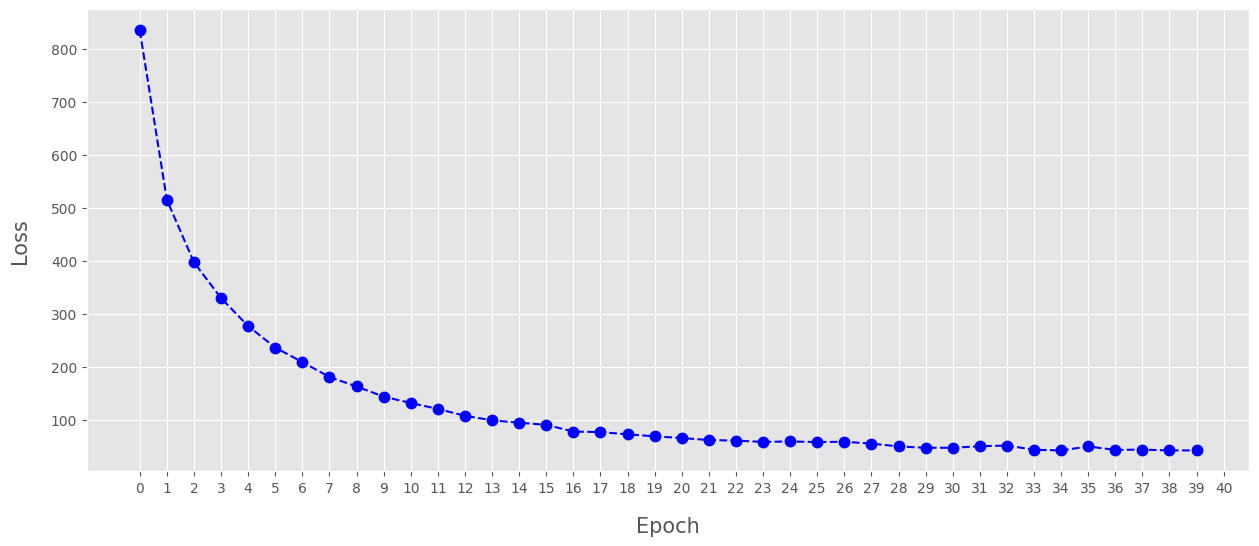

In [48]:
fontsize = 15
fig, ax = plt.subplots(1, figsize=(15, 6))

ax.plot(history['train_loss'], marker='.', ms=15, linestyle='--', color='b')

ax.set_xticks(np.linspace(0, EPOCHS, EPOCHS+1))
ax.set_xlabel('Epoch', fontsize=fontsize, labelpad=15)
ax.set_ylabel('Loss', fontsize=fontsize, labelpad=15)
